# Data Visualization

Once upon a time there were plots upon plots upon plots.

## Load data

In [1]:
import pandas as pd

# It is right in front of you. You just need to open your eyes:
df = pd.read_excel('../data/al_atlas_main_results.xlsx', index_col=0).sort_index()

## Main Figures

### Bokeh

In [2]:
import sys
sys.path.append('../')
from source.bokeh_plots import *

plot_bokeh(df)

Loading BokehJS ...

## Discovery Figures

### Kaplan-Meier Plots

#### Overall study population

In [3]:
df_train = df[df['Train-Test'] == 'Train Sample']
df_test = df[df['Train-Test'] == 'Test Sample']

df_train = df_train[df_train['Clinical Trial'].isin(['AAML0531','AAML1031',
                                                     'AAML03P1','CCG2961'])]

In [4]:
### Select samples from AAML1031, 0531, and 03P1 clinical trials
df1 = df[df['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]

print(
    f'{df.shape[0]-df1.shape[0]} samples were removed. {df1.shape[0]} samples remaining.')

### Select diagnostic samples only
df2 = df1[df1['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow', 'Primary Blood Derived Cancer - Peripheral Blood'])]

print(
    f'{df1.shape[0]-df2.shape[0]} samples were removed. {df2.shape[0]} samples remaining.')

### Remove duplicate samples
df_cog = df2[~df2['Patient_ID'].duplicated(keep='last')]

print(
    f'{df2.shape[0]-df_cog.shape[0]} samples were removed. {df_cog.shape[0]} samples remaining.')


2228 samples were removed. 1281 samples remaining.
332 samples were removed. 949 samples remaining.
9 samples were removed. 940 samples remaining.


In [5]:
# Import Plotting Functions
from source.data_visualization_functions import *

model_name = 'AML Epigenomic Risk'

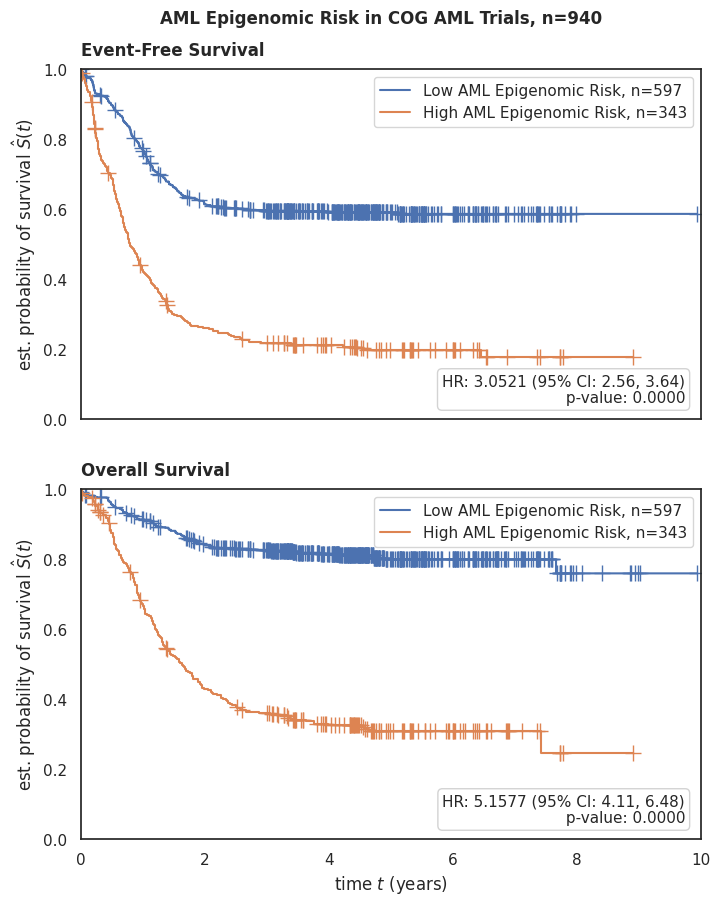

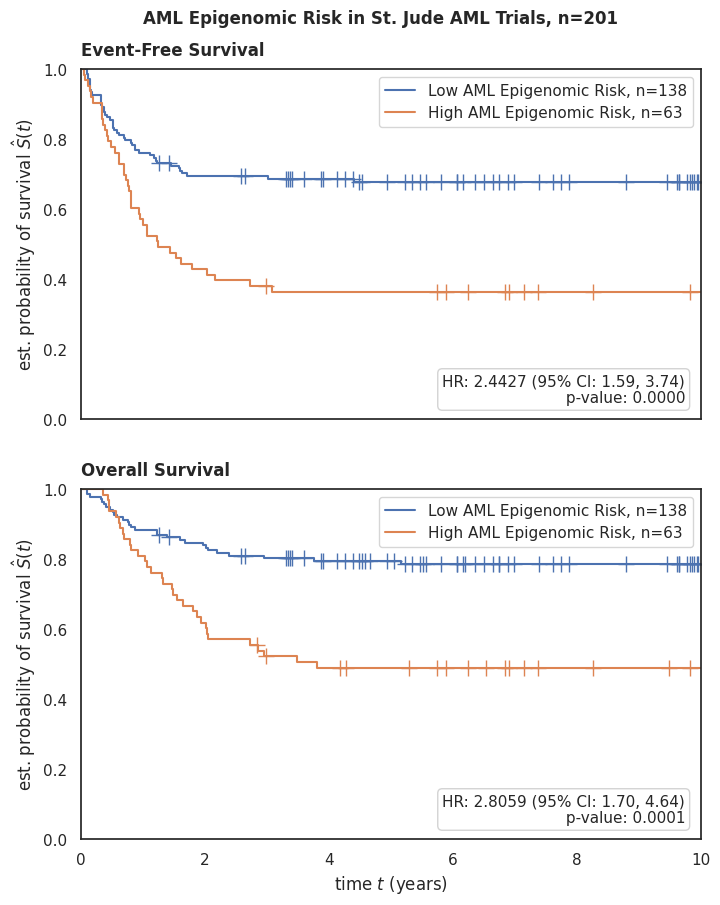

In [6]:

for dataset, trial in zip([df_cog, df_test], 
                          ['COG AML Trials', 'St. Jude AML Trials']):
    draw_kaplan_meier(model_name=model_name,
                        df=dataset,
                        save_survival_table=False,
                        save_plot=False,
                        show_ci=False,
                        add_risk_counts=False,
                        trialname=trial)

#### Per risk group

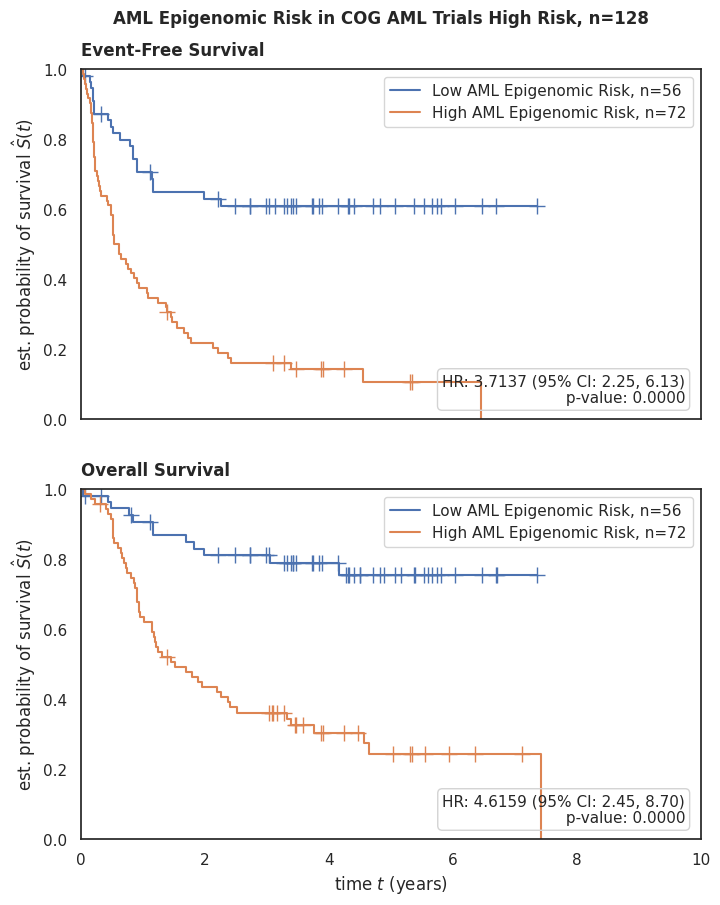

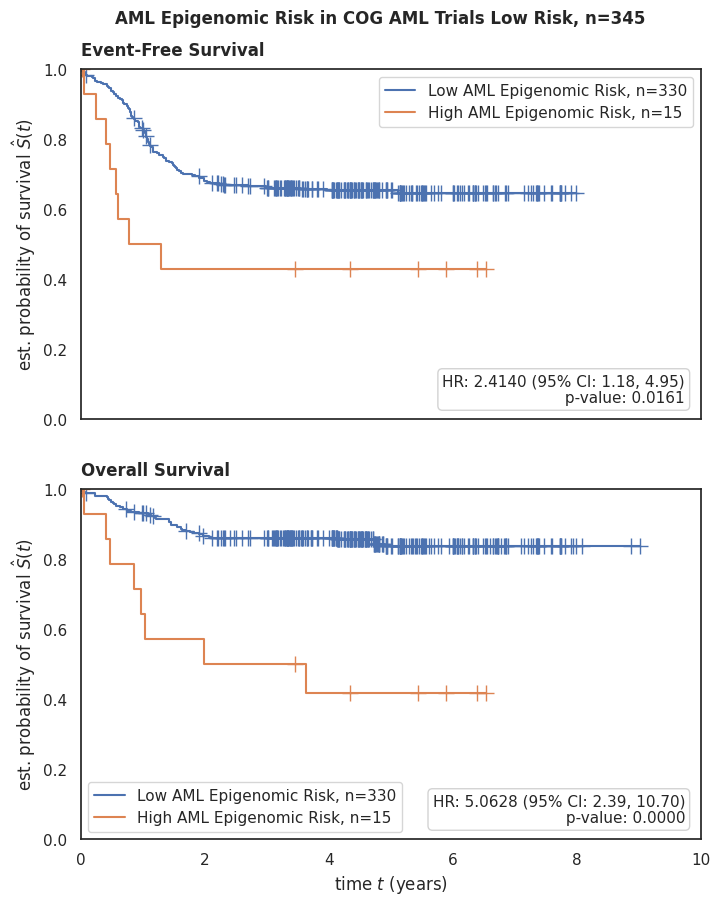

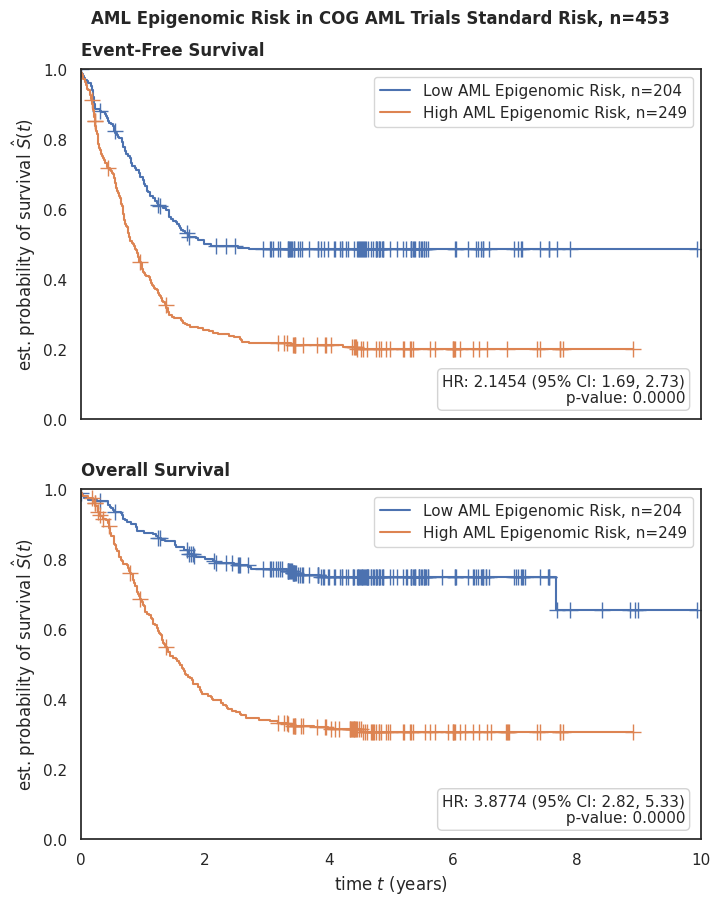

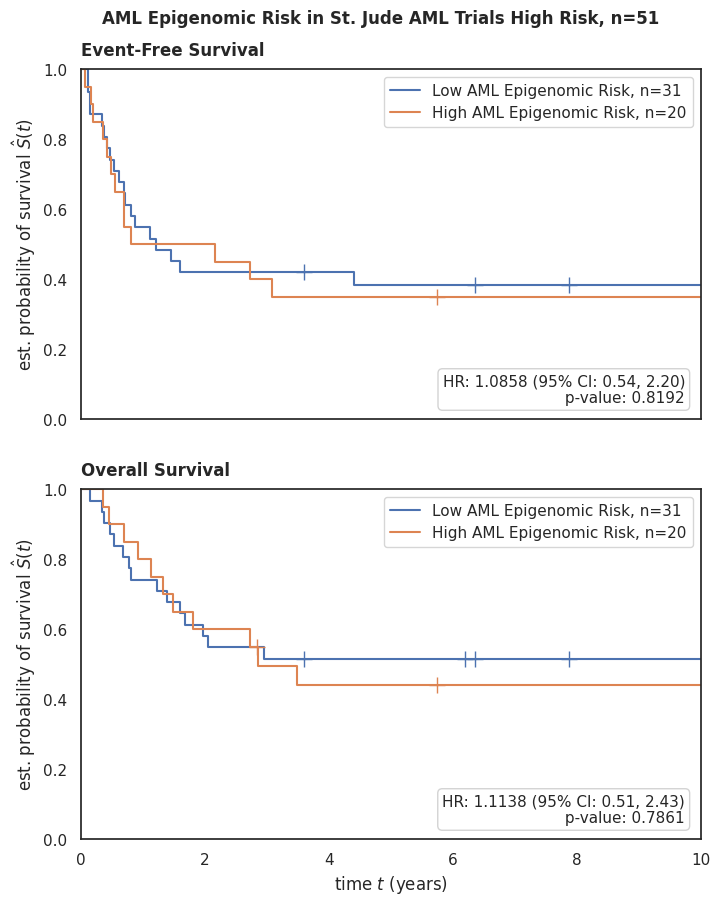

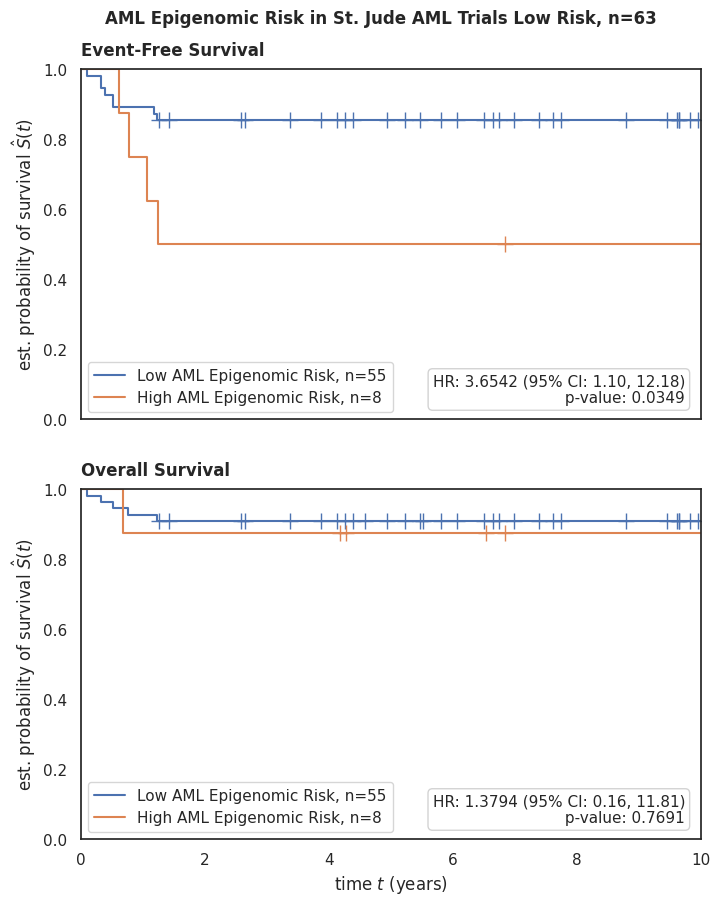

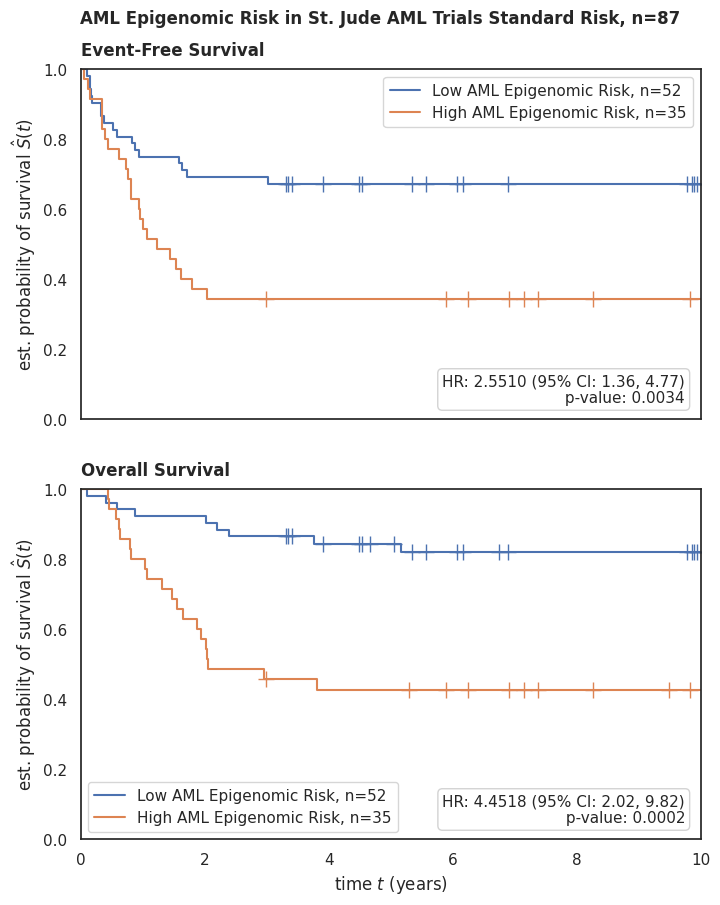

In [7]:
for dataset, trial in zip([df_cog, df_test], 
                          ['COG AML Trials', 'St. Jude AML Trials']):
    draw_kaplan_meier(model_name=model_name,
                            df=dataset[dataset['Risk Group'] == 'High Risk'],
                            save_plot=False,
                            save_survival_table=False,
                            add_risk_counts=False,
                            trialname=trial + ' High Risk')

    draw_kaplan_meier(model_name=model_name,
                            df=dataset[dataset['Risk Group'] == 'Low Risk'],
                            save_plot=False,
                            save_survival_table=False,
                            add_risk_counts=False,
                            trialname=trial + ' Low Risk')

    draw_kaplan_meier(model_name=model_name,
                            df=dataset[dataset['Risk Group'] == 'Standard Risk'],
                            save_plot=False,
                            save_survival_table=False,
                            add_risk_counts=False,
                            trialname=trial + ' Standard Risk')

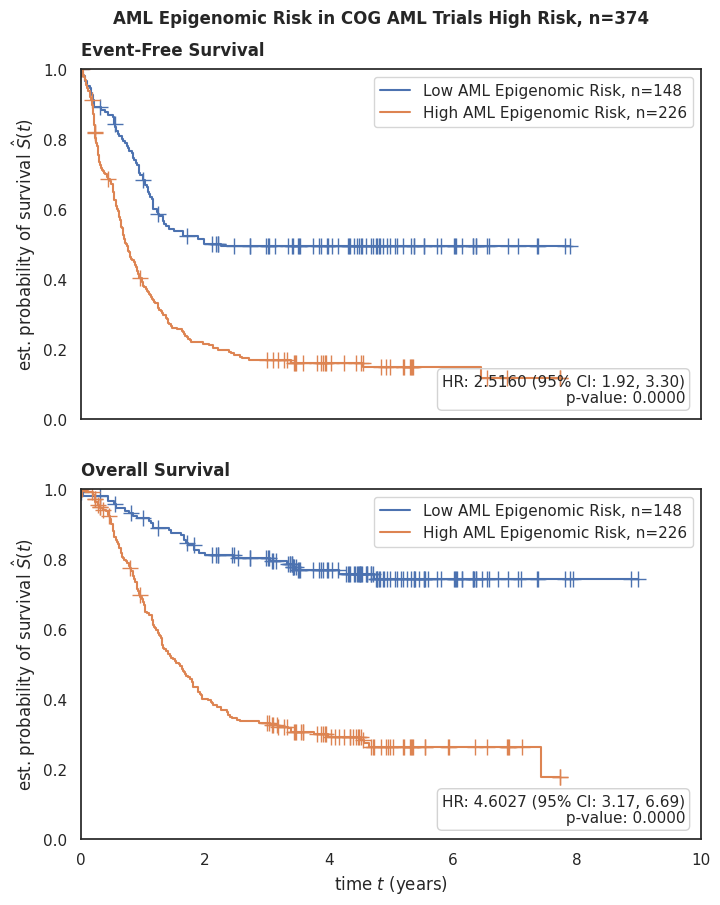

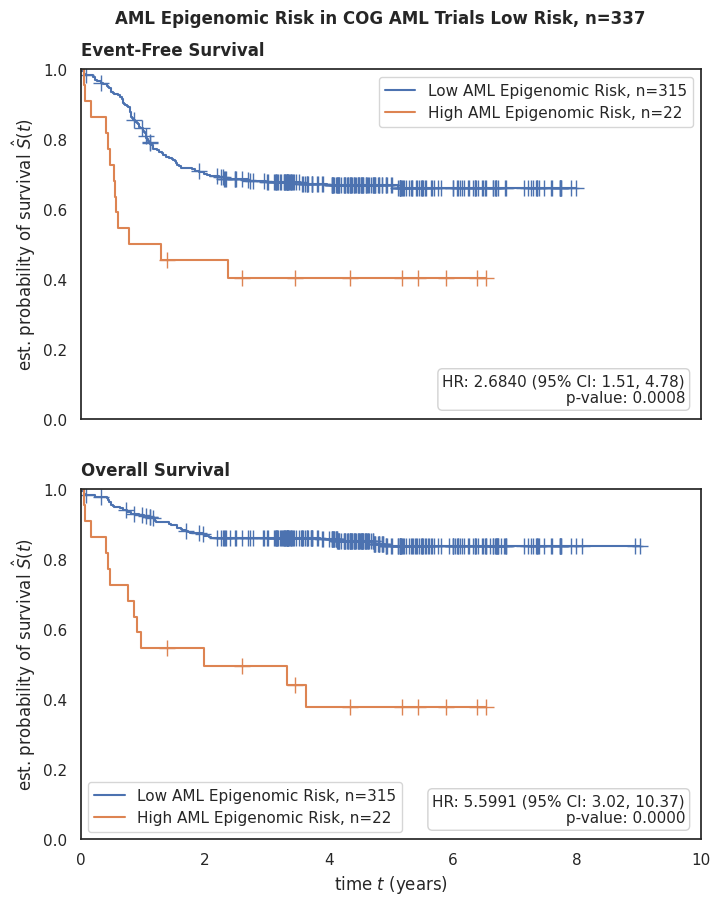

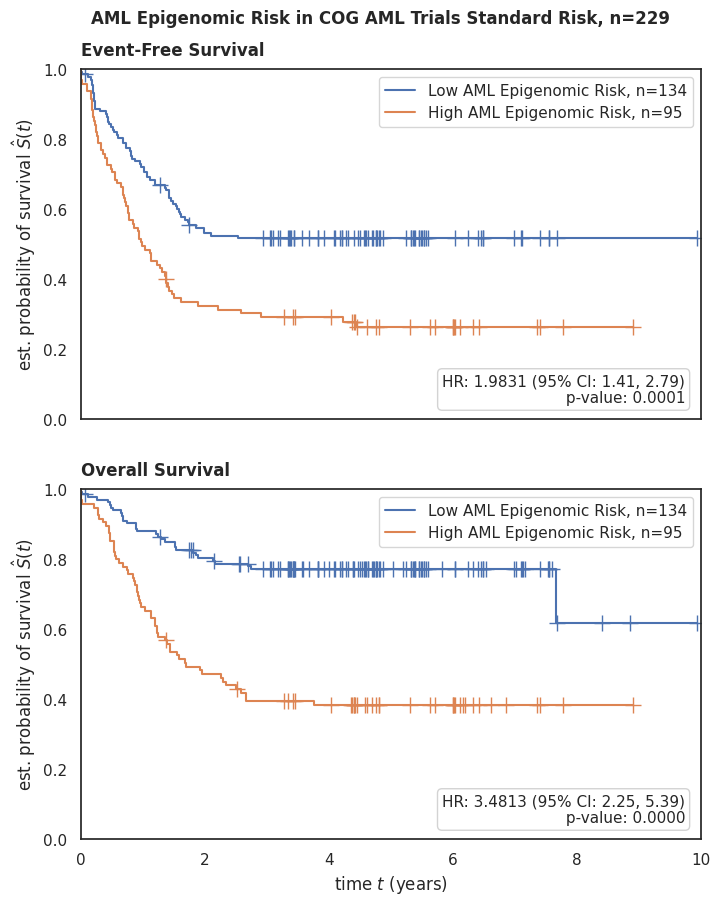

In [8]:
for dataset, trial in zip([df_cog], 
                          ['COG AML Trials']):
    draw_kaplan_meier(model_name=model_name,
                            df=dataset[dataset['Risk Group AAML1831'] == 'High'],
                            save_plot=False,
                            save_survival_table=False,
                            add_risk_counts=False,
                            trialname=trial + ' High Risk')

    draw_kaplan_meier(model_name=model_name,
                            df=dataset[dataset['Risk Group AAML1831'] == 'Low'],
                            save_plot=False,
                            save_survival_table=False,
                            add_risk_counts=False,
                            trialname=trial + ' Low Risk')

    draw_kaplan_meier(model_name=model_name,
                            df=dataset[dataset['Risk Group AAML1831'] == 'Standard'],
                            save_plot=False,
                            save_survival_table=False,
                            add_risk_counts=False,
                            trialname=trial + ' Standard Risk')

### Forest Plots

#### With MRD 1

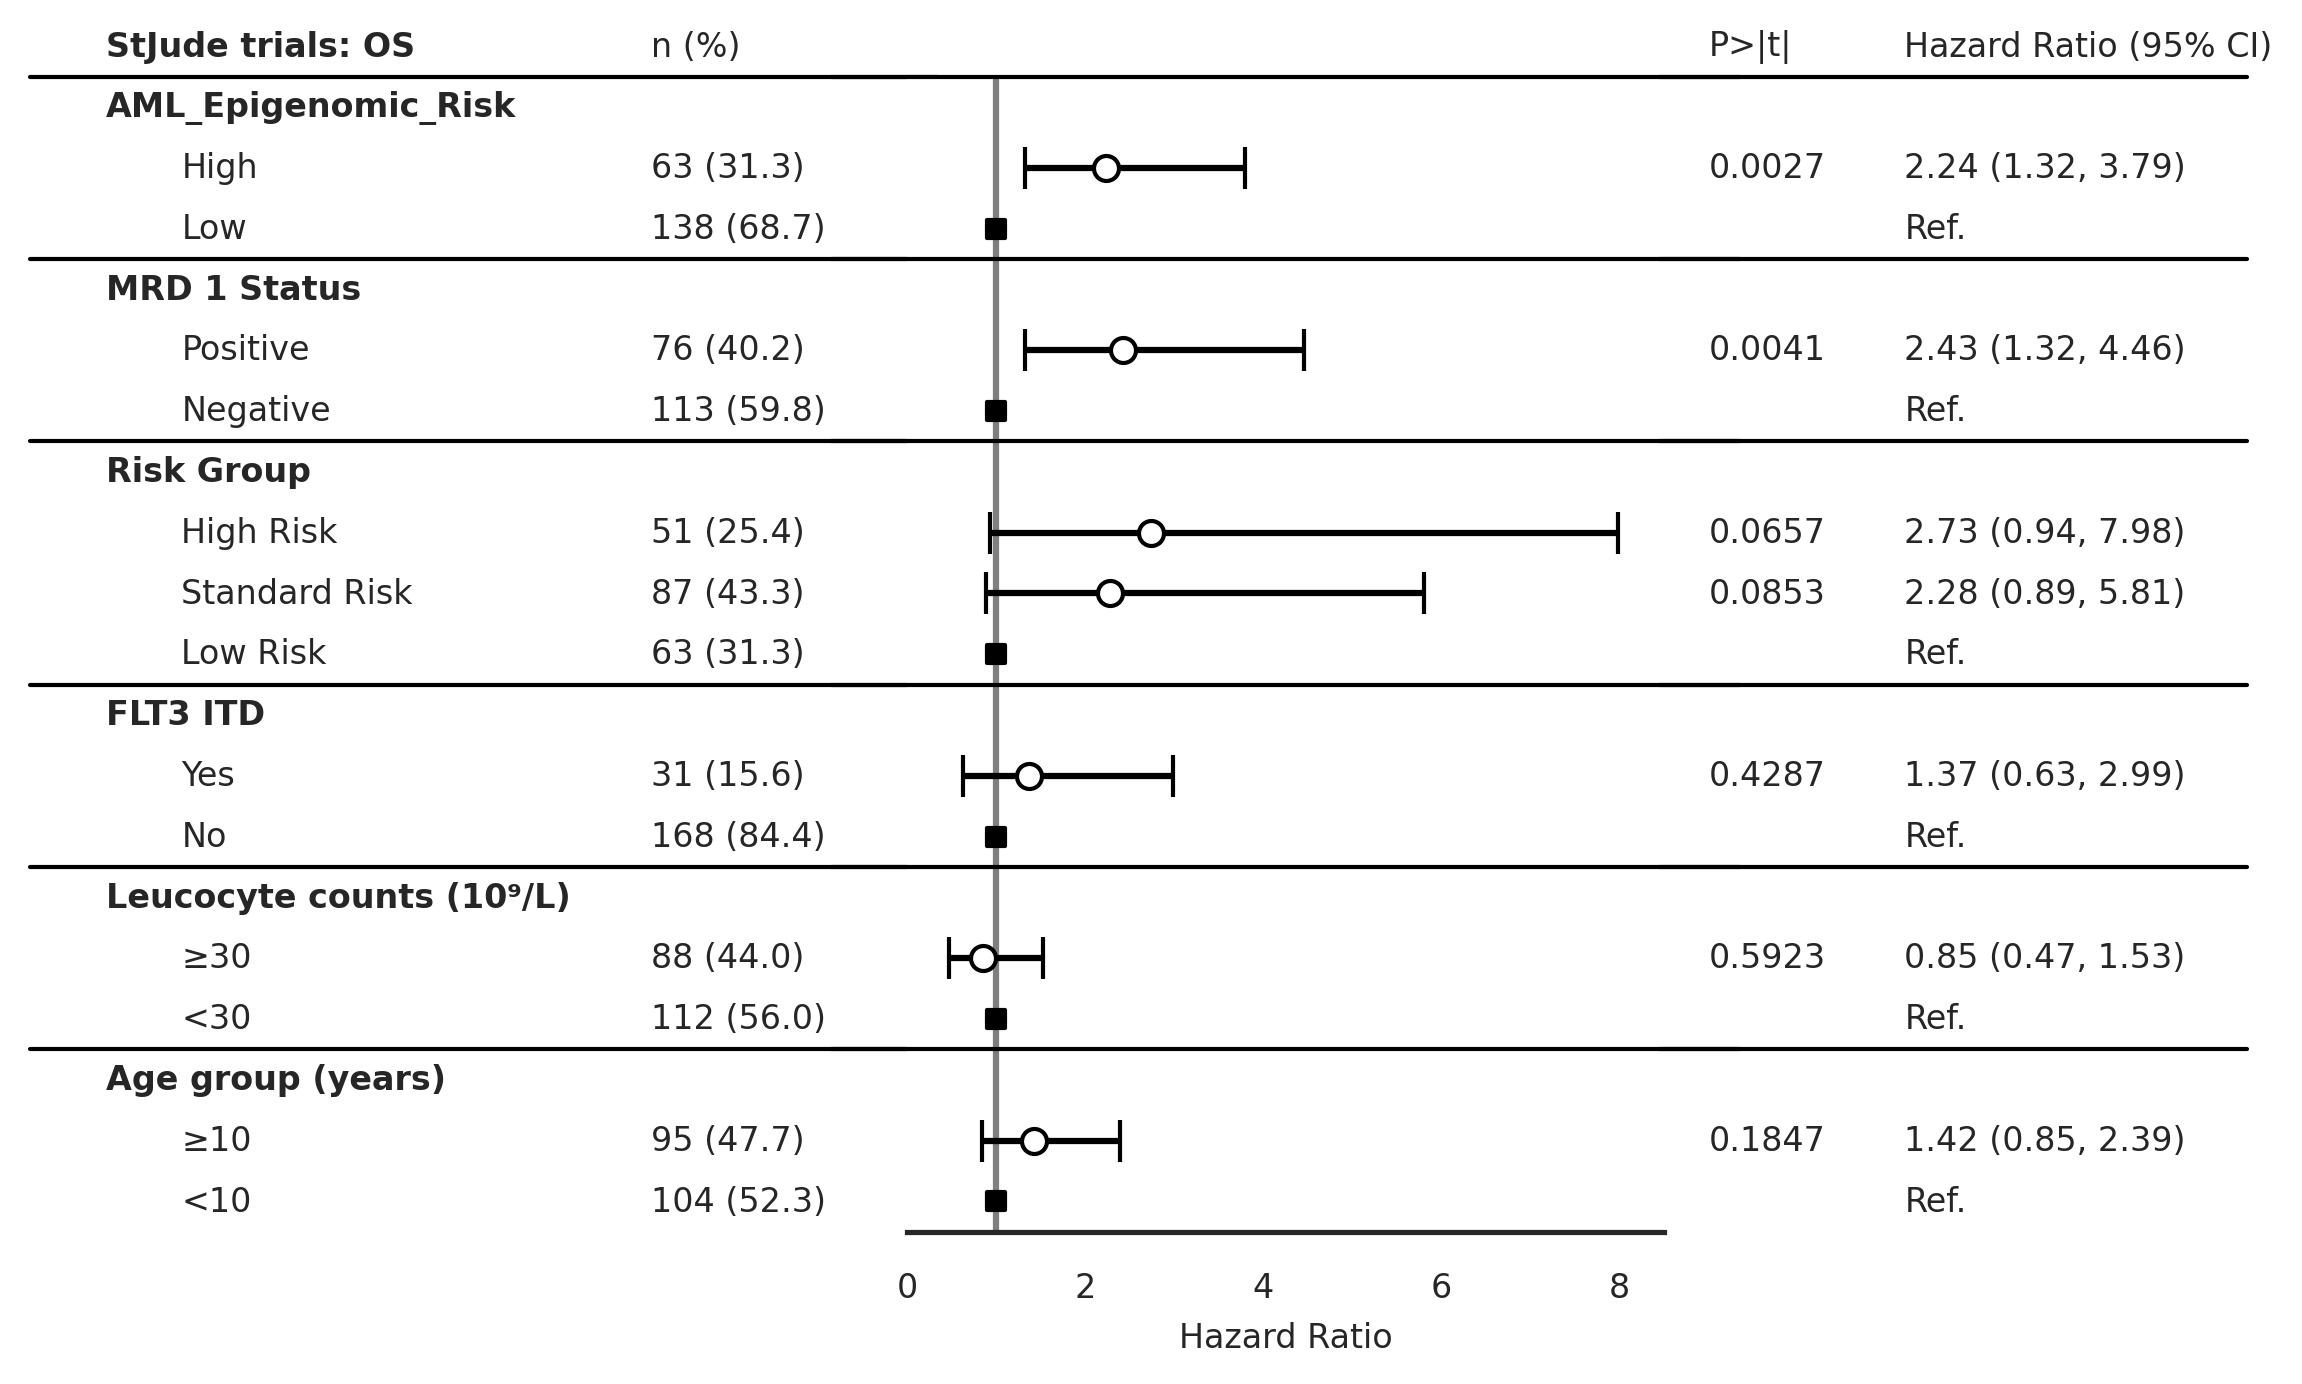

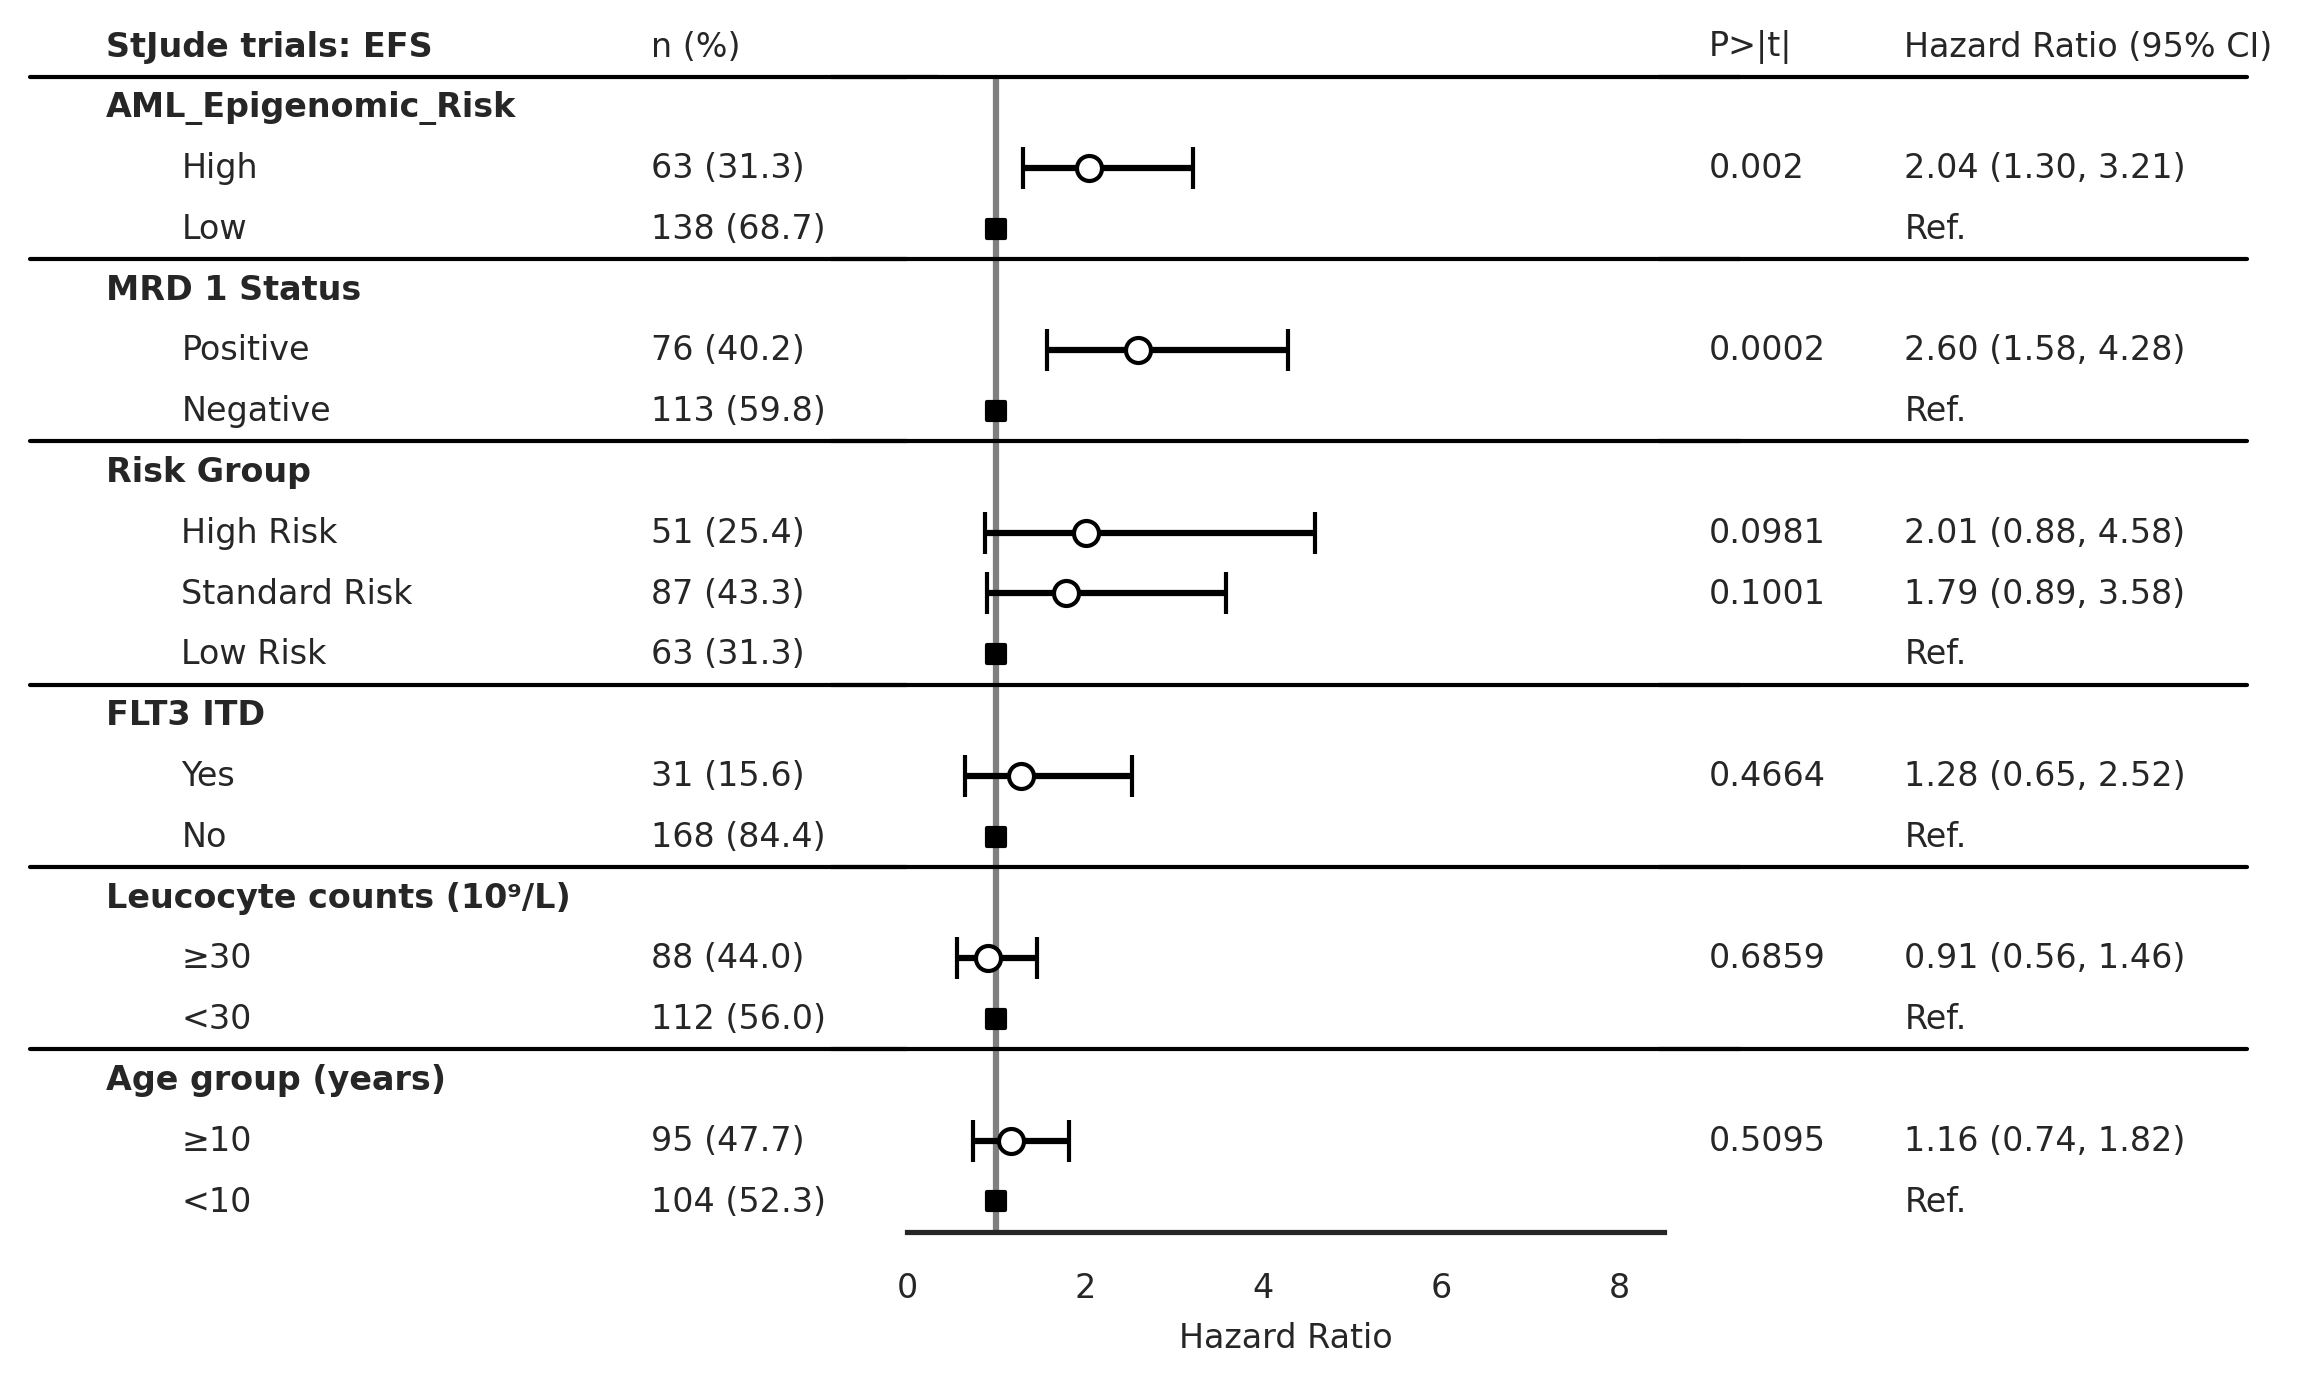

In [45]:
df_test['AML_Epigenomic_Risk'] = df_test['AML Epigenomic Risk'] 

def draw_forest_plot(time, event, df, save_plot=False, trialname=None, scorename=None):
    """
    Generates a custom forest plot.

    Parameters:
    ----------
    time: object
        List of mean coeficients from CoxPH fit.
        Note: this value has to be a pandas series.
    event: object
        Dataframe to add your results to.
    df: object
        A dataframe of variables/features that will be used to calculate the score.
    save_plot: bool, default=False
        Set to True if you wish to save the plot.It will be saved under "../Figures/ForestPlot/"
    trialname: str
        Name of your clinical trial or dataset.
    scorename: str
        Name of your model.

    Returns:
    --------
        A magnificent forest plot.

    """
    import myforestplot as mfp
    from tableone import TableOne
    import statsmodels.formula.api as smf
    import numpy as np
    
    fp = df[[scorename,
             'MRD 1 Status',
             'Risk Group',
             'FLT3 ITD',
             'Leucocyte counts (10⁹/L)',
             'Age group (years)',
             time, event]]

    event2 = event.replace('.', '_')
    time2 = time.replace('.', '_')

    if event[0] == 'o':
        event3 = 'OS'
    else:
        event3 = 'EFS'

    fp2 = fp.rename(columns={event: event2,
                             time: time2,
                             'MRD 1 Status': 'MRD_1_Status',
                             'FLT3 ITD': 'FLT3_ITD',
                             'Risk Group': 'Risk_Group',
                             'Leucocyte counts (10⁹/L)': 'WBC_count',
                             'Age group (years)': 'Age_group'})

    res = smf.phreg(formula=time2 + " ~ C("+scorename+",Treatment(reference='Low')) + C(MRD_1_Status) + C(Risk_Group,Treatment(reference='Low Risk')) + C(FLT3_ITD) + C(WBC_count) + C(Age_group)",
                    data=fp2, status=event2).fit()

    res2 = res.summary(xname=[scorename+'-High',
                              'MRD 1 Status-Positive',
                              'Risk Group-High Risk',
                              'Risk Group-Standard Risk',
                              'FLT3 ITD-Yes',
                              'Leucocyte counts (10⁹/L)-≥30',
                              'Age group (years)-≥10']).tables[1]

    res3 = res2.set_index(res2.index.str.split(pat='-', expand=True))

    mytable = TableOne(data=fp.drop(columns=[event, time]),
                       pval=False, missing=True, overall=True,
                       label_suffix=False, order={scorename: ['High'],
                                                  'MRD 1 Status': ['Positive'],
                                                  'Risk Group': ['High Risk', 'Standard Risk'],
                                                  'FLT3 ITD': ['Yes'],
                                                  'Leucocyte counts (10⁹/L)': ['≥30'],
                                                  'Age group (years)': ['≥10']}).tableone

    mytable2 = mytable.join(res3)

    mytable2["risk_pretty"] = mfp.add_pretty_risk_column(mytable2,
                                                         risk="HR",
                                                         lower='[0.025',
                                                         upper='0.975]',
                                                         fml=".2f"
                                                         )
    mytable3 = mytable2.reset_index(names=['category', 'item']).rename(columns={'HR': 'risk',
                                                                                '[0.025': 0,
                                                                                '0.975]': 1}).iloc[1:, :]

    mytable3['P>|t|'] = round(mytable3['P>|t|'], 4).replace(
        {np.nan: '', 0: '<0.0001'})

    plt.rcParams["font.size"] = 8
    fp = mfp.ForestPlot(df=mytable3,
                        ratio=[3, 3, 2],
                        fig_ax_index=[2],
                        dpi=300,
                        figsize=(9, 5),
                        vertical_align=True)
    fp.errorbar(index=2, errorbar_kwds=None)
    fp.axd[2].set_xlim([1, 8.5])
    fp.axd[2].set_xticks([0, 2, 4, 6, 8])
    fp.axd[2].set_xticklabels(labels=[0, 2, 4, 6, 8], fontdict={'fontsize': 8})
    fp.axd[2].set_xlabel("Hazard Ratio", fontsize=8)
    fp.axd[2].axvline(x=1, ymin=0, ymax=1.0, color="black", alpha=0.5)

    fp.axd[1].set_xlim([0.50, 1])
    fp.embed_cate_strings(1, "category", 0.5, header=trialname + " " + event3,
                          text_kwds=dict(fontweight="bold"),
                          header_kwds=dict(fontweight="bold"),
                          )
    fp.embed_strings(1, "item", 0.55, header="", replace={"age": ""})
    fp.embed_strings(1, "Overall", 0.86, header="n (%)")
    fp.embed_strings(3, "P>|t|", 0, header="P>|t|")
    fp.embed_strings(3, "risk_pretty", 0.4, header="Hazard Ratio (95% CI)")
    fp.horizontal_variable_separators()
    fp.draw_outer_marker(log_scale=False, scale=0.008, index=2)

    # Save plot figure
    if save_plot == True:
        plt.savefig('../Figures/Forest_Plots/' + scorename + '_' + trialname + '_' + str(len(df)) + '_' + event3 + '.png',
                    bbox_inches='tight', dpi=300)

    return (plt.show())


draw_forest_plot(time='os.time',
                    event='os.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename='AML_Epigenomic_Risk',
                    save_plot=False)

draw_forest_plot(time='efs.time',
                    event='efs.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename='AML_Epigenomic_Risk',
                    save_plot=False)

#### Without MRD 1

In [ ]:
# draw_forest_plot_noMRD(time='os.time',
#                     event='os.evnt',
#                     df=df_test,
#                     trialname='StJude trials:',
#                     scorename='AML_Epigenomic_Risk',
#                     save_plot=False)

# draw_forest_plot_noMRD(time='efs.time',
#                     event='efs.evnt',
#                     df=df_test,
#                     trialname='StJude trials:',
#                     scorename='AML_Epigenomic_Risk',
#                     save_plot=False)

### ROC AUC

In [ ]:
# Your current preprocessing
df_test['Risk Group bins'] = df_test['Risk Group'].replace({'Low Risk':0, 'Standard Risk':0.5, 'High Risk':1})
df_test['MRD 1 bins'] = df_test['MRD 1 Status'].replace({'Negative':0, 'Positive':1})
df_test2 = df_test[['os.evnt', model_name + '_int', 'Risk Group bins', 'MRD 1 bins']].dropna()

# rename column `MethylScoreAML_Px_cat_bin` to `MethylScoreAML Px`
df_test2 = df_test2.rename(columns={model_name + '_int':model_name})

# Add new columns based on standardized values
df_test2['MRD1 + Risk Group'] = df_test['MRD 1 bins'] + df_test['Risk Group bins']
df_test2['MRD1 + Risk Group + MethylScore'] = df_test['MRD 1 bins'] + df_test['Risk Group bins'] + df_test[model_name + '_int']


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def plot_roc_auc(df, score_columns, outcome_column, trial_name='validation cohort'):
    """
    Plots the ROC AUC curves for multiple models given a dataframe and multiple score columns.
    
    Parameters:
    - df (pd.DataFrame): Dataframe containing the score and outcome columns.
    - score_columns (list of str): List of names of columns that contain the scores.
    - outcome_column (str): The name of the column that contains the true outcomes.
    
    Returns:
    None
    """
    
    plt.figure()
    plt.title('ROC AUC in ' + trial_name + ', n={}'.format(len(df)))
    
    # plot random guessing line
    plt.plot([0, 1], [0, 1], 'r--')

    # binarize the outcome variable
    lb = LabelBinarizer()
    lb.fit(df[outcome_column])
    y = lb.transform(df[outcome_column])
    
    # Loop over score_columns to plot multiple ROC curves
    for score_column in score_columns:
        
        # calculate the fpr and tpr for all thresholds of the classification
        fpr, tpr, threshold = roc_curve(y, df[score_column])
        roc_auc = auc(fpr, tpr)
        
        # plot ROC curve for this score_column
        plt.plot(fpr, tpr, label=f'{score_column} AUC = %0.2f' % roc_auc)

    # set x and y limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # set x and y labels
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    # add legend
    plt.legend(loc='lower right')
    plt.show()

# Example Usage:
score_columns = [model_name, 'Risk Group bins', 'MRD 1 bins', 'MRD1 + Risk Group', 'MRD1 + Risk Group + MethylScore']
outcome_column = 'os.evnt'
plot_roc_auc(df_test2, score_columns, outcome_column)



### Box Plots

In [ ]:
draw_boxplot(df=df_test,x='Risk Group', y='P(Dead)',
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='StJude trials', hue=model_name,
                save_plot=False, figsize=None)

draw_boxplot(df=df_test,x='MRD 1 Status', y='P(Dead)',
                order=['Positive','Negative'],
                trialname='StJude trials', hue=model_name,
                save_plot=False, figsize=None)

draw_boxplot(df=df_test,x='Primary Cytogenetic Code', y='P(Dead)',
                order='auto',
                trialname='StJude trials', hue=model_name,
                save_plot=False, figsize=None)

### Stacked Bar Plots

In [ ]:
draw_stacked_barplot(df=validation_clinical_data,x='MRD 1 Status', y=score_name,
             order=['Positive','Negative'],
             trialname='StJude trials', hue=score_name + ' Categorical',
             save_plot=False, figsize=None)

draw_stacked_barplot(df=validation_clinical_data,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=9)

draw_stacked_barplot(df=validation_clinical_data,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=6)



### Patient Characteristics Table

#### Overall study population

In [ ]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD','Treatment Arm']

validation_clinical_data['Age (years)'] = validation_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(validation_clinical_data, columns,
                        overall=False, missing=True,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']})

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_validation_cohort.csv')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','Validation Cohort'])

#### Including both discovery and validation cohorts

In [ ]:
# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

discovery_clinical_data['Age (years)'] = discovery_clinical_data['Age (years)'].astype(float)

px = discovery_clinical_data.loc[ewas_top_cpgs.index]

dx = discovery_clinical_data
# [~discovery_clinical_data['ELN 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
#                                        'Myeloid leukaemia associated with Down syndrome',
#                                        'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]
dx = dx[~dx['WHO 2022 Diagnosis'].isna()]

# Use only samples from df_index
dx = dx[dx.index.isin(pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=1).index)]

# join discovery clinical data with validation clinical data
all_cohorts = pd.concat([dx, px, validation_clinical_data],
                         axis=0, keys=['MethylScoreAML Dx Discovery','MethylScoreAML Px Discovery' ,'Validation'],
                         names=['cohort']).reset_index()


columns = ['Age group (years)','Sex', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)',
            'Risk Group','FLT3 ITD', 'Treatment Arm','Clinical Trial']

mytable_cog = TableOne(all_cohorts, columns,
                        overall=False, missing=False,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                                groupby='cohort')

mytable_cog.to_excel('../data/tableone_both_cohorts.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        # headers=[score_name,"",score_name,'Validation','p-value','Statistical Test']
)

#### By MethylScore category

In [ ]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD']

validation_clinical_data['Age (years)'] = validation_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(validation_clinical_data, columns,
                        overall=False, missing=True,
                        pval=True, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                        groupby=score_name + ' Categorical')

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_validation_methylscoreaml_px.csv')
mytable_cog.to_excel('../data/tableone_validation_methylscoreaml_px.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','High','Low','p-value','Statistical Test'])

## Watermark

In [ ]:
%load_ext watermark

In [ ]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,statannotations -a Francisco_Marchi@Lamba_Lab_UF -d -m